# Практическое задание
## Урок 5. Случайный лес

#### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).<br>Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets, model_selection

import numpy as np

In [2]:
classification_data, classification_labels = datasets.make_classification(
    n_samples=100,
    n_features = 2, n_informative = 2, n_classes = 2, n_redundant=0, n_clusters_per_class=1, random_state=69)

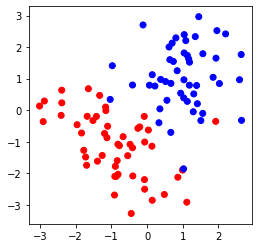

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(4,4))
plt.scatter(classification_data[:, 0], 
            classification_data[:, 1], 
            c=classification_labels, cmap=colors)
plt.show()

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                    classification_labels, 
                                                                                    test_size = 0.3,
                                                                                    random_state = 42)

### Визуализация моделей

In [18]:
n_estimators = [1, 3, 10, 50]

forests = []
for i in n_estimators:
    forests.append(random_forest(train_data, train_labels, n_trees=i))

In [19]:
def accuracy(y_true, y_pred):
    return np.count_nonzero(y_true == y_pred) / y_true.shape[0]

def get_meshgrid(data, step=.02, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def meshgrid_plot(train_data, test_data, train_labels, test_labels, forest, i, ax):
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    ax.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    
    pred_train_labels = tree_vote(forest, train_data)
    pred_test_labels = tree_vote(forest, test_data)
    
    ax.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors, s=10)
    ax.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors, marker='+')
    
    ax.set_title(f'n_estimators={n_estimators[i]}, train_accuracy={accuracy(train_labels, pred_train_labels):.2f}, test_accuracy={accuracy(test_labels, pred_test_labels):.2f}')

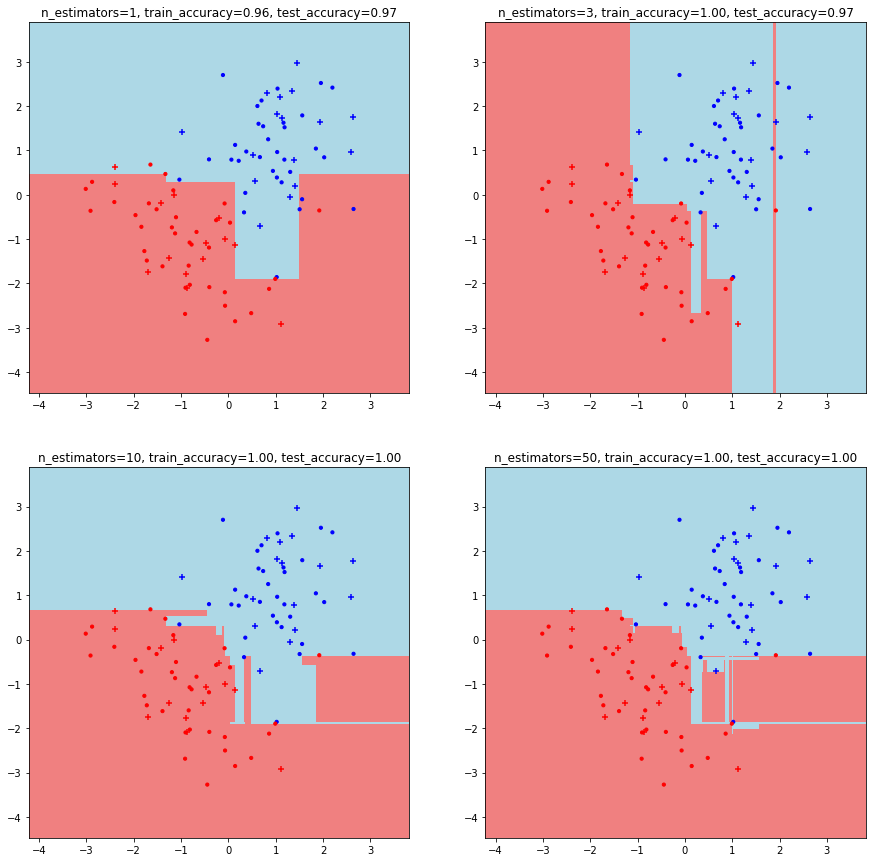

In [20]:
fig, axs = plt.subplots((len(forests) + 1) // 2, 2, figsize=(15, 15))
axs = axs.reshape(-1)
for i, forest in enumerate(forests):
    meshgrid_plot(train_data, test_data, train_labels, test_labels, forest, i, axs[i])

Сложность разделения гиперплоскости и переобучение растет с числом деревьев.

В данном примере одиночное дерево выглядит недообученным, ансамбль из трех деревьев сработал хорошо, а из 10-ти и 50-ти слишком сложно разделил пространство и выглядит переобученным.

#### 2*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

Если я правильно понял, то для классификации вместо второго аргумента, будет не среднее по результатам предсказаний деревьев, построенных без участия выбранного примера, а метка класса, выбранная методом голосования на основе этих предсказанных результатов.

Будем использовать функцию потерь:

$$L(i, j)=\left\{\begin{array}{ll}
0 & i=j \\
1 & i \neq j
\end{array}\right.$$

Тогда OOB покажет для скольки примеров предсказание будет неверно 

Тогда `accuracy = 1 - OOB / l`, где `l` - число примеров в выборке.

In [21]:
def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    
    # По всем испытаниям считаем предсказание на основе деревьев постоенных без их участия
    # и на основе всех таких деревьев считаем предсказание голосованием
    oob_preds = []
    for sample_row, sample in enumerate(data):
        sample_preds = []
        for forest_num, (b_data, b_labels) in enumerate(bootstrap):
            if sample not in b_data:
                sample_preds.append(classify_object(sample, forest[forest_num]))
        if len(sample_preds) == 0:
            oob_preds.append(labels[sample_row])
        else:
            oob_preds.append(sum(sample_preds) / len(sample_preds) > .5)
    
    oob = len(labels) - np.count_nonzero(labels == oob_preds)
    
    return forest, oob

In [25]:
n_estimators = [5, 10, 20, 50]
for i, n_est in enumerate(n_estimators):
    forest, oob = random_forest_oob(classification_data, classification_labels, n_trees=n_est)
    print(f'number_of_trees = {n_estimators[i]}, OOB = {oob}')

number_of_trees = 5, OOB = 11
number_of_trees = 10, OOB = 9
number_of_trees = 20, OOB = 6
number_of_trees = 50, OOB = 7


Если в нашем примере выбирать число деревьев на основе результатов OOB, то 20 деревьев оптимально. 

При большем числе деревьев, например, 50-ти будет переобучение, так как ошибка выросла, при меньшем недообучение.

#### 3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

In [30]:
# Расчет энтропийного критерия

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p != 0:  # при p=0, слагаемое = 0 и поэтому не влияет на критерий
            impurity -= p * np.log2(p)
        
    return impurity